## 1 Multi-Class Classification

For this exercise, you will use logistic regression and neural networks to
recognize handwritten digits (from 0 to 9). In the first part of the exercise, you will extend your previous implementation of logistic regression and apply it to one-vs-all classification.

In [2]:
# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

In [3]:
#  training data stored in arrays X, y
data = loadmat('machine-learning-ex3/ex3/ex3data1.mat')
X, y = data['X'], data['y']

# Set the '10' label for 0 back to '0'
y[y == 10] = 0

In [4]:
print(X.shape)
print(y.shape)

(5000, 400)
(5000, 1)


### 1.2 Visualizing the data

You will begin by visualizing a subset of the training set. Create a grid to display 100 examples of the data.

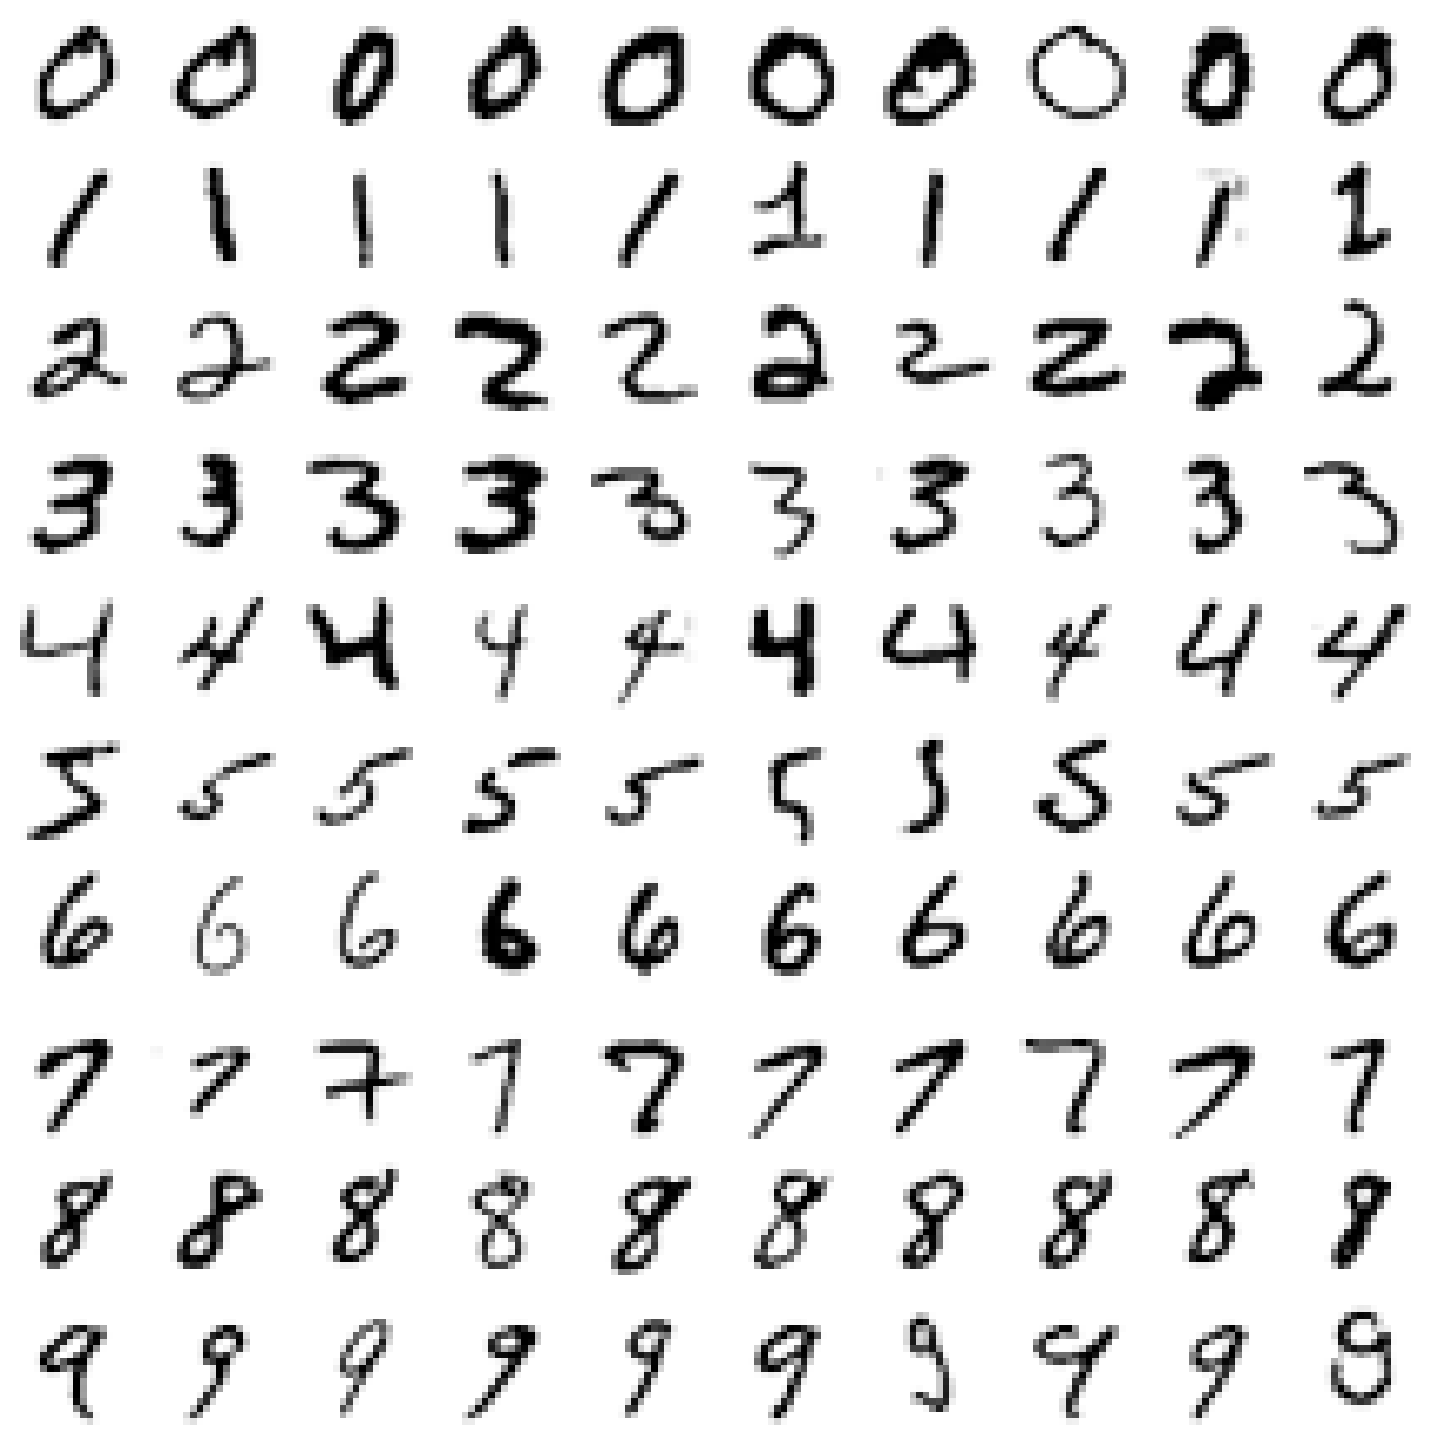

In [5]:
def create_grid(data, labels, digits=range(0,10), num_examples=10, figsize=(20,20), axes='off'):
    
    '''
    Creates a grid that visualizes a specified number of examples of
    each digit specified in the digits array. Each row in the grid contains
    the number of examples and each column is the range of digits in the
    digits array in descending order. By default, the digits are 0-9 and
    the number of examples is set to 10.
    '''
    
    # Create the grid of subplots
    fig, ax = plt.subplots(len(digits), num_examples, figsize=figsize)
    
    # Create a counter of examples for each digit and a set that breaks the loop 
    # when all digits have been added to it
    counter_list = [0] * len(digits)
    break_set = set()
    
    # Loop through the data and labels and plot the appropriate digits until the 
    # number of examples has been reached for each digit
    for digit, label in zip(data, labels):
        
        label = int(label)
        
        # Skip the label if it is not one of the specified digits
        if label not in digits:
            continue
        
        else:
            if counter_list[digits.index(label)] < num_examples:
                grid = digit.reshape((20,20), order='F')
                
                # If there is only one digit specified, the subplots are in a 1-dimensional array
                if len(digits) == 1:
                    plot_digit(grid, ax[counter_list[digits.index(label)]], axes=axes)
                
                # Else, the subplots are in a 2-dimensional array
                else:
                    plot_digit(grid, ax[digits.index(label)][counter_list[digits.index(label)]], axes=axes)
                    
                counter_list[digits.index(label)] += 1

            elif counter_list[digits.index(label)] == num_examples:
                break_set.add(label)

            if len(break_set) == len(digits):
                break
    
    # Show the final grid
    fig.tight_layout()
    plt.show()    

def plot_digit(digit, ax, axes):
    
    '''
    Renders/plots the digit matrix on top of a specified ax.
    '''
    
    # Plot the digit matrix and turn off the axis labels
    ax.imshow(digit, cmap ='Greys', vmin = 0, vmax = 1) 
    ax.axis(axes)

# Plot the grid
create_grid(X, y)

### 1.3 Vectorizing Logistic Regression

Since there are 10 classes, you will need to train 10
separate logistic regression classifiers. To make this training efficient, it is
important to ensure that your code is well vectorized. In this section, you
will implement a vectorized version of logistic regression that does not employ
any for loops. You can use your code in the last exercise as a starting point
for this exercise.

#### 1.3.1 Vectorizing the (unregularized) cost function

In [6]:
# Define a sigmoid function implementation
def sigmoid(x):
    
    return 1/(1+np.exp(-x))

In [7]:
# Define the cost function
def cost_function(X, y, theta):
    
    # Define the hypothesis function
    hypothesis = sigmoid(X.dot(theta.T))
    
    # Compute the dot products of the vectors to be summed over the number of samples
    to_sum = -y.dot(np.log(hypothesis)) - (1-y).dot(np.log(1-hypothesis))
    
    # Return the sum of the samples
    return np.sum(to_sum)/len(y)

#### 1.3.2 Vectorizing the (unregularized) gradient descent function

In [8]:
# Define the gradient descent function

def gradient_descent(X, y, theta, alpha, iterations):
        
    thetas = []
        
    for i in range(iterations):  
                
        # Find the hypothesis function via cross product of X and theta tranposed
        hypothesis = sigmoid(X.dot(theta.T))
                
        # Calculate the value of the derivative of the cost function with regularization
        cost_derivative = (hypothesis-y).dot(X)
                
        # Simultaneously update the theta parameter vector
        theta = theta - ((alpha/len(y))*cost_derivative)
        thetas.append(theta)
    
    return thetas

#### 1.3.3 Vectorizing regularized logistic regression

In [9]:
# Define the regularized cost function
def reg_cost_function(theta, X, y, lamda):

    # Set theta_0 to zero so it does not get regularized
    temp = theta
    temp[0] = 0
    
    # Normal cost function without regularization
    hypothesis = sigmoid(X.dot(theta.T))
    non_reg = np.sum(-y.dot(np.log(hypothesis)) - (1-y).dot(np.log(1-hypothesis)))
    
    # Regularization
    reg = (lamda/2)*np.sum(np.power(temp,2))
        
    return (non_reg + reg)/len(y)

In [10]:
# Define the regularized gradient descent function

def reg_gradient_descent(X, y, theta, lamda, alpha, iterations):
        
    thetas = []
    
    for i in range(iterations):  
        
        # Find the hypothesis function via dot product of X and theta tranposed
        hypothesis = sigmoid(X.dot(theta.T))
        
        # Set a temp theta to leave theta_0 unregularizaed
        temp_theta = theta
        temp_theta[0] = 0
                
        # Calculate the value of the derivative of the cost function with regularization
        cost_derivative = (hypothesis-y).dot(X) + lamda*temp_theta
        
        # Simultaneously update the theta parameter vector
        theta = theta - ((alpha/len(y))*cost_derivative)
        thetas.append(theta)
        
    return thetas

In [11]:
# Create a combined cost and gradient function without gradient descent so that we can 
# use the optimizer from scipy to find the thetas using the Truncated Newton method

def reg_costandgrad(theta, X, y, lamda):
    
    # Hypothesis function
    hypothesis = sigmoid(X.dot(theta.T))
        
    # Set theta_0 to zero so it does not get regularized
    temp = theta
    temp[0] = 0
    
    # Normal cost function without regularization
    non_reg = np.sum(-y.dot(np.log(hypothesis)) - (1-y).dot(np.log(1-hypothesis)))
    
    # Regularization
    reg = (lamda/2)*np.sum(np.power(temp,2))
     
    # Cost function
    J = (non_reg + reg)/len(y)

    # Calculate the value of the derivative of the cost function with regularization
    cost_derivative = (hypothesis-y).dot(X) + lamda*temp

    # Simultaneously update the theta parameter vector to return the gradient
    grad = (1/len(y))*cost_derivative
    
    return J, grad.flatten()

### 1.4 One-vs-all Classification

In this part of the exercise, you will implement one-vs-all classification by
training multiple regularized logistic regression classifiers, one for each of
the K classes in our dataset.

In [12]:
def one_vs_all_train(logisticfunc, X, y, num_labels, lamda, max_iters):
        
    # Initialize the theta matrix for all classes to be returned
    all_thetas = np.zeros((num_labels, X.shape[1]))
    
    # Initialize the theta vector
    initial_theta = np.zeros(X.shape[1])
    
    for label in range(num_labels):
        y_temp = (y == label).astype(int)
        all_thetas[label] = optimize.minimize(logisticfunc, initial_theta, (X, y_temp, lamda), jac = True, 
                                              method='CG', options={'maxiter': max_iters}).x
    
    return all_thetas

In [13]:
# Initialize the parameters for one vs all classification training function   
num_labels = 10 
lam = 1
max_iters = 100

# Reshape X and y to perform vector calculations
y_grad = y.reshape(1,-1)
X_grad = np.hstack((np.ones((X.shape[0], 1)), X))

# Return the thetas parameter array for each class
all_thetas = one_vs_all_train(reg_costandgrad, X_grad, y_grad, num_labels, lam, max_iters)

/Users/samuelguytemlock/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


In [14]:
print(all_thetas.shape)

(10, 401)


In [15]:
print(y.shape)

(5000, 1)


#### 1.4.1 One-vs-all Prediction

Use the trained classifiers to predict the digit contained in a given image. For each input, compute the "probability" that it belongs to each class using the trained lgositic regression classifiers. The prediction function will pick the class for which the corresponding classifier outputs the highest probability and return the label.

In [16]:
def one_vs_all_predict(all_thetas, X, y):
    
    # Calculate the hypothesis for each example across the classes
    hypotheses = sigmoid(X.dot(all_thetas.T))
    
    # Find the predicted class for each example
    predicts = np.argmax(hypotheses, axis=1).reshape(-1,1)
    
    # Compare the predicted class to the actual class for each example
    correct = (predicts == y).astype(int)
    
    # Print the accuracy score
    accuracy = np.sum(correct)/correct.shape[0]
    
    return correct, accuracy
    
correct_array, accuracy = one_vs_all_predict(all_thetas, X_grad, y)
print(f"Training set accuracy: {accuracy*100}%")

Training set accuracy: 94.46%


## 2 Neural Networks

In this part of the exercise, implement a neural network to recognize handwritten digits using the same training set as before. The neural
network will be able to represent complex models that form non-linear hypotheses. The goal is to implement the feedforward
propagation algorithm to use our weights for prediction. In next week's exercise, you will write the backpropagation algorithm for learning the neural
network parameters.

In [17]:
# Reload the data to make sure there was no manipulation of the data
X, y = data['X'], data['y']

y[y == 10] = 0

In [28]:
print(X.shape)
print(y.shape)

(5000, 400)
(5000, 1)


### 2.1 Model Representation

Since the images are of size 20x20, this gives us 400 input layer
units (excluding the extra bias unit which always outputs +1). The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [32]:
# Load the weights
weights = loadmat('machine-learning-ex3/ex3/ex3weights.mat')

# Extract theta1 (hidden layer) and theta2 (output layer)
theta1, theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing
theta2 = np.roll(theta2, 1, axis=0)

print(theta1.shape)
print(theta2.shape)

(25, 401)
(10, 26)


### 2.2 Feedforward Propagation and Prediction

In [41]:
def forward_propagation_predict(X, thetas, y):
    
    # Transform the input data to be column vecotrs
    a = X.T
    
    # For every layer of weights, perform the forward propagation and activation
    for weights in thetas:
        a = np.vstack((np.ones(a.shape[1]), a))
        z = weights.dot(a)
        a = sigmoid(z)

    # Find the softmax for each example 
    predicts = np.argmax(a, axis=0).reshape(-1,1)
    
    # Compare the predicted class to the actual class for each example
    correct = (predicts == y).astype(int)
    
    # Calculate the accuracy score
    accuracy = np.sum(correct)/correct.shape[0]
    
    return accuracy, predicts

Training set accuracy: 97.52%


In [42]:
# Create a list of the layer weights
thetas = [theta1, theta2]

# Predict the input examples
score, predicted = forward_propagation_predict(X, thetas, y)

print(f"Training set accuracy: {score*100}%") 

Training set accuracy: 97.52%
